- we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

- compute a Histogram of Oriented Gradients (HOG) as well as a color histogram using the hue channel in HSV color space(方向梯度直方图 + 色彩直方图)

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
print(X_train_feats.shape)
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
print(X_val_feats.shape)
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])
print(X_test_feats.shape)

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [4]:
from cs231n.classifiers.linear_classifier import LinearSVM
learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]
results = {}
best_val = -1
best_svm = None

# for lr in learning_rates:
#     for reg in regularization_strengths:
for lr in np.arange(1e-7,5e-5, 1e-6):
    for reg in np.arange(2.5e4,  5e4, 1e5):
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, lr, reg, num_iters=5000, verbose=False)
        train_acc = (svm.predict(X_train_feats) == y_train).mean()
        val_acc = (svm.predict(X_val_feats) == y_val).mean()
        results[(lr, reg)] = (train_acc, val_acc)
        if best_val < val_acc:
            best_val = val_acc
            best_svm = svm
for lr , reg in sorted(results):
    train_acc, val_acc = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy : %f' % (
            lr, reg, train_acc, val_acc))
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.163980 val accuracy : 0.174000
lr 1.100000e-06 reg 2.500000e+04 train accuracy: 0.384510 val accuracy : 0.387000
lr 2.100000e-06 reg 2.500000e+04 train accuracy: 0.405592 val accuracy : 0.416000
lr 3.100000e-06 reg 2.500000e+04 train accuracy: 0.406020 val accuracy : 0.397000
lr 4.100000e-06 reg 2.500000e+04 train accuracy: 0.408469 val accuracy : 0.405000
lr 5.100000e-06 reg 2.500000e+04 train accuracy: 0.413306 val accuracy : 0.424000
lr 6.100000e-06 reg 2.500000e+04 train accuracy: 0.413265 val accuracy : 0.418000
lr 7.100000e-06 reg 2.500000e+04 train accuracy: 0.415367 val accuracy : 0.416000
lr 8.100000e-06 reg 2.500000e+04 train accuracy: 0.419959 val accuracy : 0.426000
lr 9.100000e-06 reg 2.500000e+04 train accuracy: 0.420612 val accuracy : 0.430000
lr 1.010000e-05 reg 2.500000e+04 train accuracy: 0.422918 val accuracy : 0.431000
lr 1.110000e-05 reg 2.500000e+04 train accuracy: 0.422531 val accuracy : 0.420000
lr 1.210000e-05 

In [5]:
y_test_pred = best_svm.predict(X_test_feats)
test_acc = np.mean(y_test == y_test_pred)
print(test_acc)

0.467


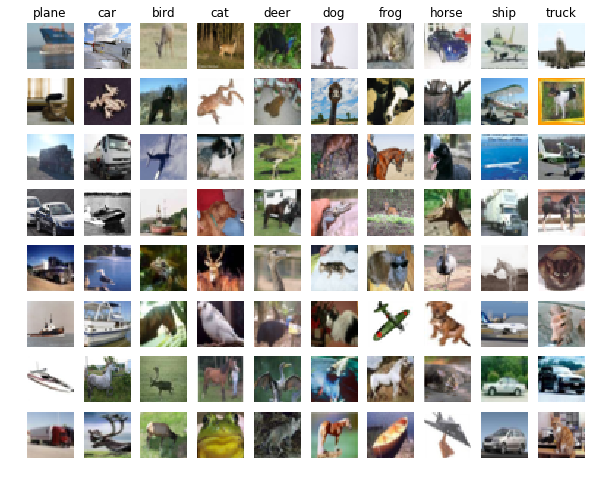

In [6]:
examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for  cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i*len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

Inline question 1: 大体依据边缘确定

In [7]:
print(X_train_feats.shape)

(49000, 155)


In [9]:
from cs231n.classifiers.neural_net import TwoLayerNet
input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10
best_net = None
best_params = {'hidden_size':hidden_dim, 'num_iters':1000,
               'learning_rate':1e-4, 'reg':0.25, 
               'learning_rate_decay':0.95,}
max_count = 50
for count in range(max_count):
    reg = 10 ** random.uniform(-5, 0)
    lr = 10 ** random.uniform(-2, 1)
    num_iters = 1000
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)

    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                     num_iters = num_iters, batch_size=1000,
                     learning_rate=lr, learning_rate_decay=0.95,
                     reg = reg, verbose=False)
    val_acc = (net.predict(X_val_feats) == y_val).mean()
    print('no:%d layer:%d reg:%.8f lr:%f val_acc:%.8f ' % (count+1, hidden_dim, reg, lr, val_acc))
    if best_val < val_acc:
        best_val = val_acc
        best_net = net
        best_params['learning_rate'] = lr
        best_params['reg'] = reg
        
# no:3 layer:500 reg:0.00050266 lr:0.755859 val_acc:0.59200000
# no:40 layer:500 reg:0.00002859 lr:0.894140 val_acc:0.59600000 
# no:4 layer:500 reg:0.00008136 lr:2.301749 val_acc:0.59900000 

no:1 layer:500 reg:0.00017073 lr:0.023488 val_acc:0.21800000 
no:2 layer:500 reg:0.01070206 lr:1.063743 val_acc:0.52800000 


C:\Users\Administrator\Desktop\cs231n\assignment1\cs231n\classifiers\neural_net.py:100: RuntimeWarning: overflow encountered in add
  prob = np.exp(scores + logc) / np.sum(np.exp(scores + logc), axis = 1, keepdims=True)
C:\Users\Administrator\Desktop\cs231n\assignment1\cs231n\classifiers\neural_net.py:100: RuntimeWarning: invalid value encountered in add
  prob = np.exp(scores + logc) / np.sum(np.exp(scores + logc), axis = 1, keepdims=True)
C:\Users\Administrator\Desktop\cs231n\assignment1\cs231n\classifiers\neural_net.py:80: RuntimeWarning: invalid value encountered in maximum
  rl = np.maximum(0, fc1)
C:\Users\Administrator\Desktop\cs231n\assignment1\cs231n\classifiers\neural_net.py:120: RuntimeWarning: invalid value encountered in less_equal
  drl[rl <= 0] = 0


no:3 layer:500 reg:0.96298326 lr:9.193715 val_acc:0.08700000 
no:4 layer:500 reg:0.00008136 lr:2.301749 val_acc:0.59900000 
no:5 layer:500 reg:0.00020433 lr:0.035129 val_acc:0.26800000 
no:6 layer:500 reg:0.00016377 lr:3.426507 val_acc:0.56700000 
no:7 layer:500 reg:0.00006143 lr:1.567062 val_acc:0.58000000 
no:8 layer:500 reg:0.00006900 lr:0.020976 val_acc:0.21600000 
no:9 layer:500 reg:0.00576232 lr:0.024285 val_acc:0.22000000 
no:10 layer:500 reg:0.00030188 lr:8.250375 val_acc:0.08700000 
no:11 layer:500 reg:0.00529714 lr:0.030205 val_acc:0.21400000 
no:12 layer:500 reg:0.00761581 lr:0.015528 val_acc:0.11600000 
no:13 layer:500 reg:0.00018314 lr:2.123899 val_acc:0.58700000 
no:14 layer:500 reg:0.08893740 lr:4.432543 val_acc:0.11300000 


C:\Users\Administrator\Desktop\cs231n\assignment1\cs231n\classifiers\neural_net.py:102: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * (np.sum(W1 ** 2) + np.sum(W2 ** 2))


no:15 layer:500 reg:0.00001329 lr:8.120099 val_acc:0.08700000 
no:16 layer:500 reg:0.00001247 lr:0.561489 val_acc:0.59200000 
no:17 layer:500 reg:0.00141139 lr:4.261441 val_acc:0.59100000 
no:18 layer:500 reg:0.20276965 lr:0.015301 val_acc:0.07800000 
no:19 layer:500 reg:0.00001061 lr:0.030363 val_acc:0.22500000 
no:20 layer:500 reg:0.00065213 lr:0.393636 val_acc:0.56100000 


C:\Users\Administrator\Desktop\cs231n\assignment1\cs231n\classifiers\neural_net.py:102: RuntimeWarning: overflow encountered in square
  loss += reg * (np.sum(W1 ** 2) + np.sum(W2 ** 2))


no:21 layer:500 reg:0.00007732 lr:9.881693 val_acc:0.08700000 
no:22 layer:500 reg:0.00287821 lr:0.358866 val_acc:0.55100000 
no:23 layer:500 reg:0.04942120 lr:0.321174 val_acc:0.44400000 
no:24 layer:500 reg:0.00178039 lr:8.930659 val_acc:0.08700000 
no:25 layer:500 reg:0.07576562 lr:1.882890 val_acc:0.36100000 
no:26 layer:500 reg:0.23119371 lr:0.072420 val_acc:0.07900000 
no:27 layer:500 reg:0.00539284 lr:0.424390 val_acc:0.53700000 
no:28 layer:500 reg:0.00251103 lr:0.024372 val_acc:0.23200000 
no:29 layer:500 reg:0.00090157 lr:0.237219 val_acc:0.52600000 
no:30 layer:500 reg:0.26451692 lr:0.043474 val_acc:0.08700000 
no:31 layer:500 reg:0.11665047 lr:0.117269 val_acc:0.28500000 
no:32 layer:500 reg:0.11019090 lr:0.024027 val_acc:0.07900000 
no:33 layer:500 reg:0.01468055 lr:5.008622 val_acc:0.10200000 
no:34 layer:500 reg:0.04442948 lr:0.214580 val_acc:0.44500000 
no:35 layer:500 reg:0.00138835 lr:3.453708 val_acc:0.59200000 
no:36 layer:500 reg:0.00038612 lr:0.011114 val_acc:0.07

In [10]:
test_acc = (best_net.predict(X_test_feats)==y_test).mean()
print('test_acc: %f' % test_acc)

test_acc: 0.587000
